# Generative Adversarial Network for Generating Fashion MNIST Images

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.utils import plot_model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

Using TensorFlow backend.


# Read Fashion MNIST Images and Normalize

In [ ]:
((images_train, _), (_, _)) = fashion_mnist.load_data()

In [ ]:
images_train = (np.array(images_train).astype(np.float32) - 127.5)/127.5
images_train = images_train.reshape(60000, 784)

In [ ]:
# Define the Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [ ]:
# Dimension of the Noise Vector
randomDim = 100

# Define the Generator

In [ ]:
# Define the Generator
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

# Define the Discriminator

In [ ]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

# Define the GAN with the Generator and the Discriminator

In [ ]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


### Define a Custom Function for Plotting the Generated Images

In [ ]:
def plotGeneratedImages(epoch=10, examples=100, dim=(10, 10), figsize=(10, 10), randDim=100):
    noise = np.random.normal(0, 1, size=[examples, randDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### A Custom Function to Train the GAN

In [ ]:
def train(images, epochs=1, batchSize=128, randomDim=100):
    batchCount = int(images.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    # Number of epochs the Network will be trained
    # In every epoch a number of batches of images will be generated
    # The network will be created and the Network will be Trained
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)

        # The network is gettting trained on a batch of images
        for idx in range(batchCount):

            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim]) # batchSize no. of noise vectors
                                                                        # each of dimension randomDim          

            # Select batchSize number of random indices for the images to be selected from the training dataset                                                            
            imageBatch = images[np.random.randint(0, images.shape[0], size=batchSize)]

            # Generate Fake Fashion MNIST images 
            # The Generator generates fake images from random noise
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)

            # Create Training data for the Discriminator
            # Now, create a set of training images X by taking batchSize no. of original (Real) images from the training set
            # and all the fake images generated by the Generator in the previous step
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize) # 200 dim vector

            #if (idx==0):
            #  print(batchSize)
            #  print(yDis.shape)

            # One-sided label smoothing
            # First batchSize number of images are the Real images
            # Rest are Fake images generated by the Generator
            yDis[:batchSize] = 0.9

            # Train the Discriminator
            # The training will be performed on the batch of images
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train the GAN
            # Generator is getting trained now- we are basically training the GAN turining off the Discriminator
            # batchSize no. of noise vectors each of dimension randomDim are generated to train the Generator
            # Remember, the Generator does not see that Real images
            # It is trained on noise vectors          
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)

            # When training the Generator, we don't want to train the Discriminator (it is already trained)
            # Now the Discriminator gives feedback as to what it thinks (Real/Fake) of the image generated by the Generator
            # During this training process, the Generator will improve itself in generating more realistic fake images so that
            # eventually the Discriminator is unable to distinguish a generated Fake image from a Real one
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

     
        if e == 1 or e % 5 == 0:
            plotGeneratedImages(e)
            


## Train the GAN

Epochs: 50
Batch size: 100
Batches per epoch: 600
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
--------------- 

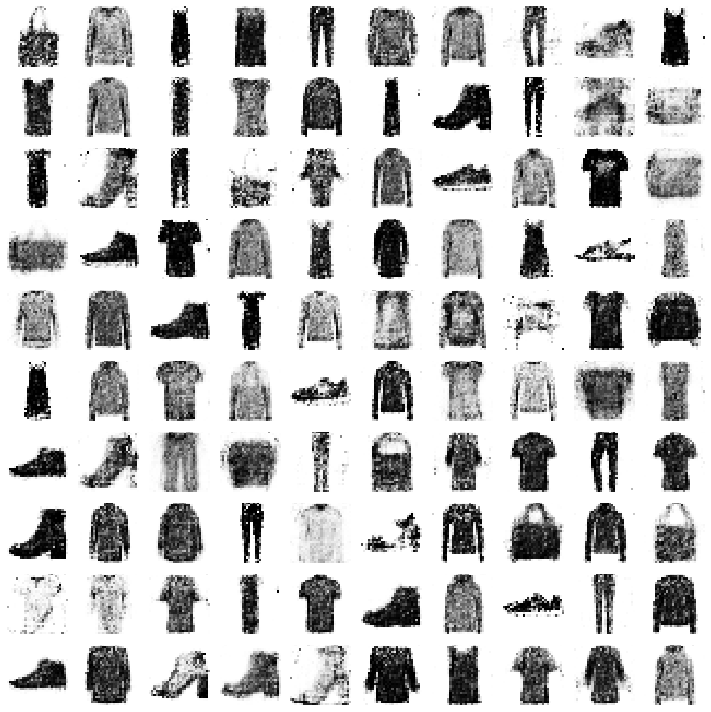

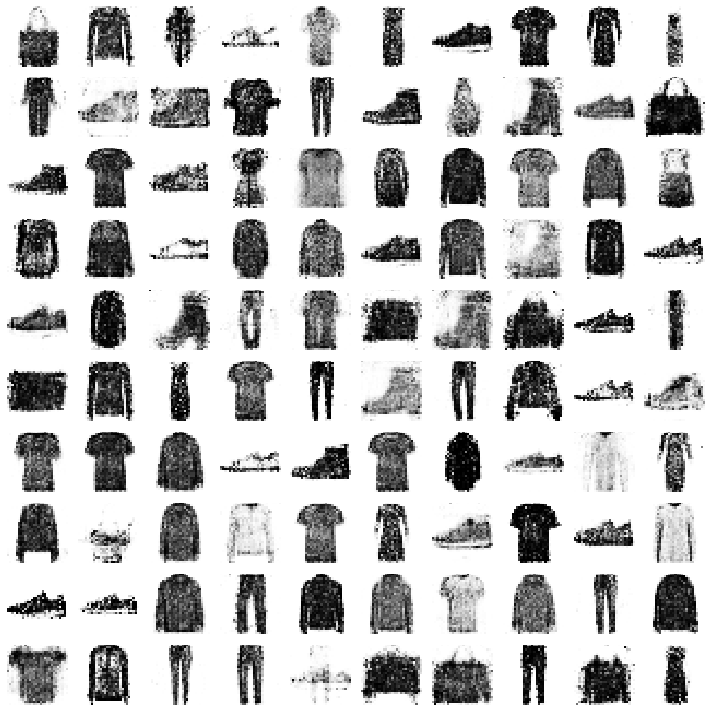

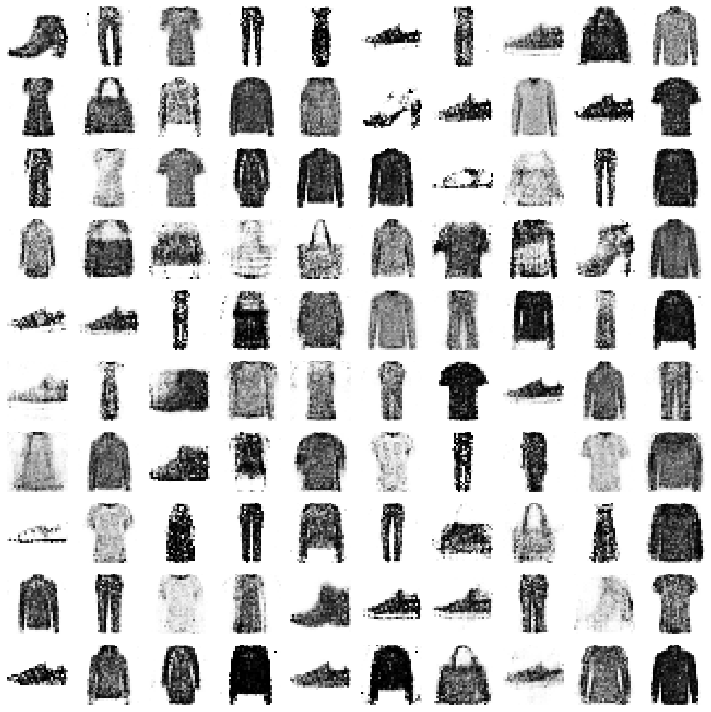

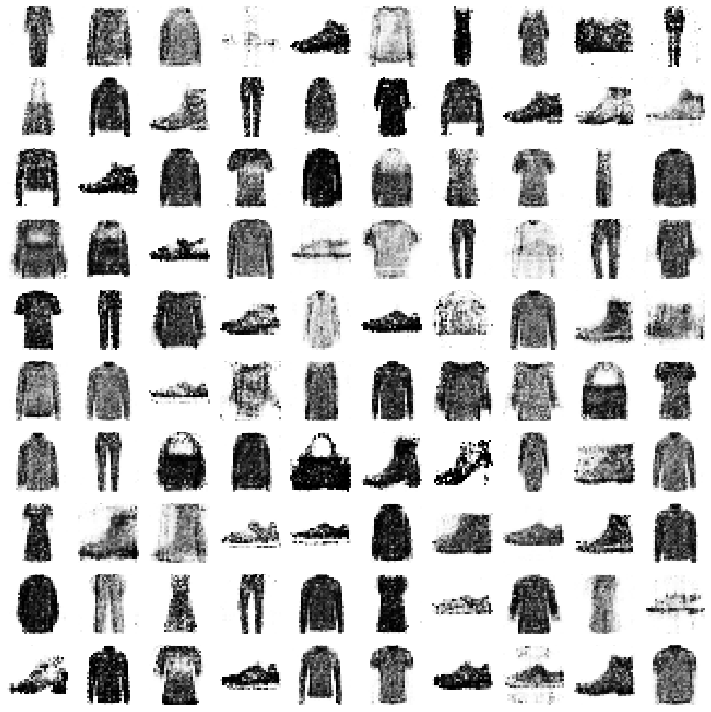

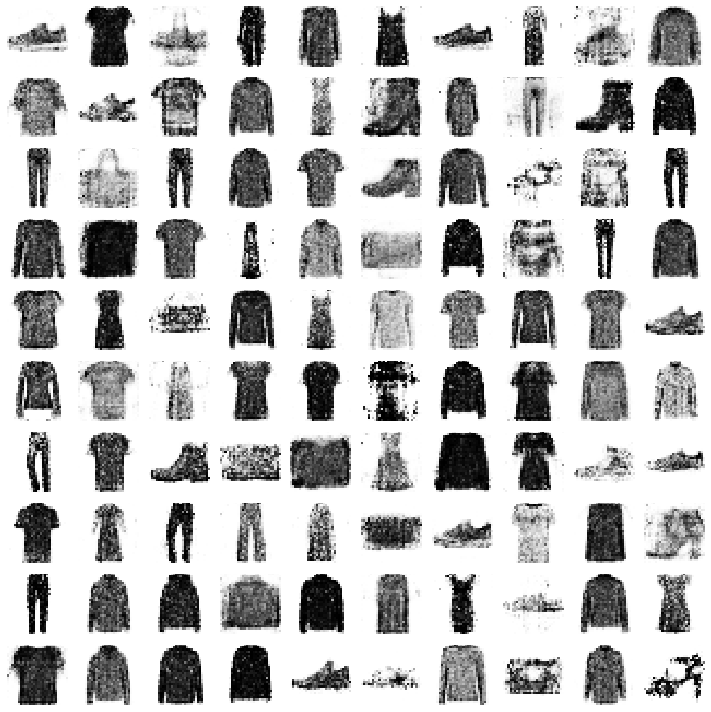

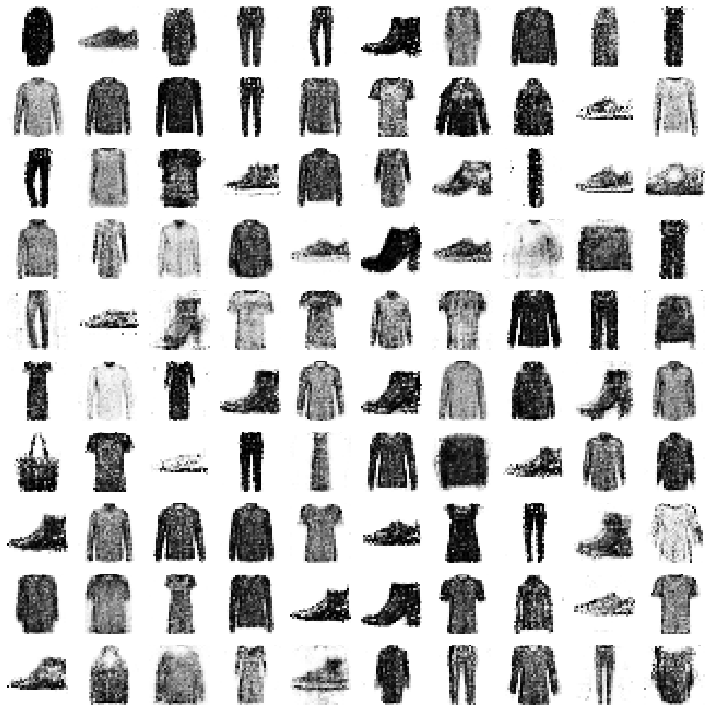

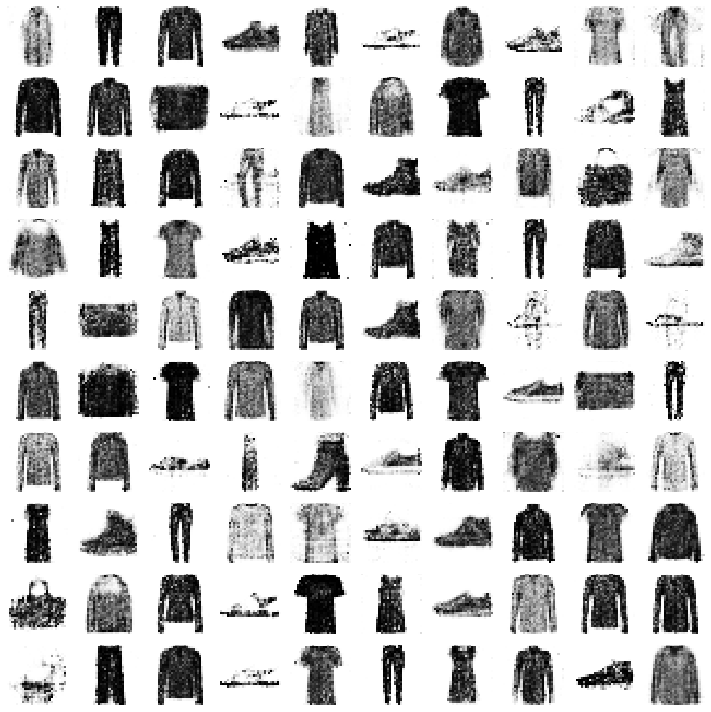

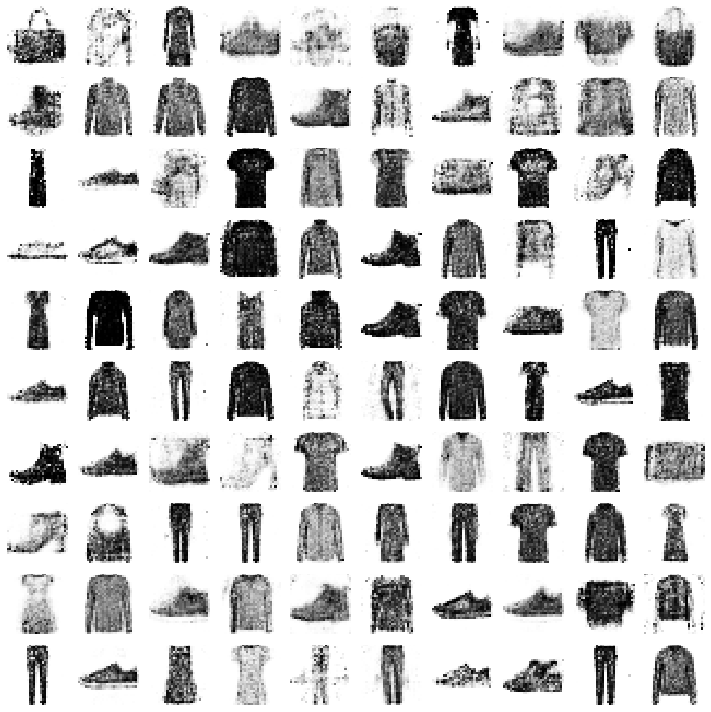

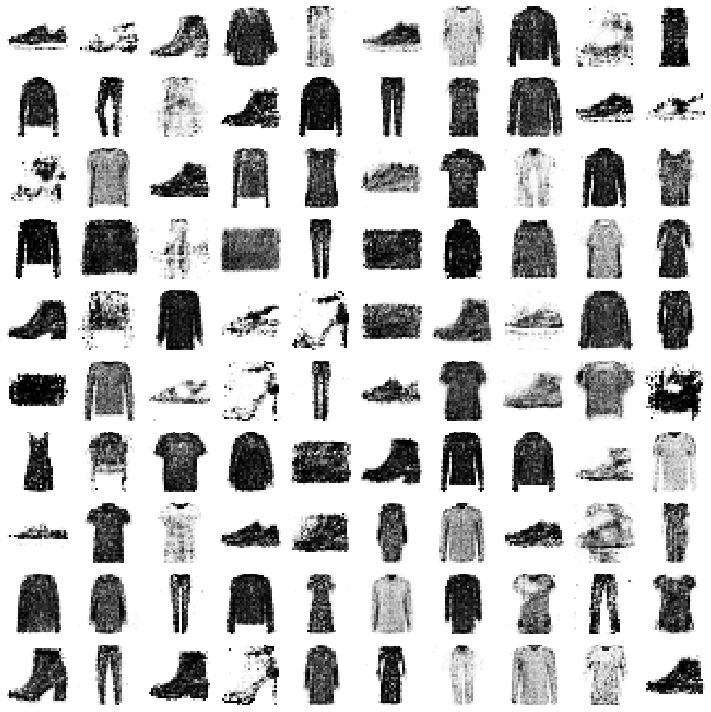

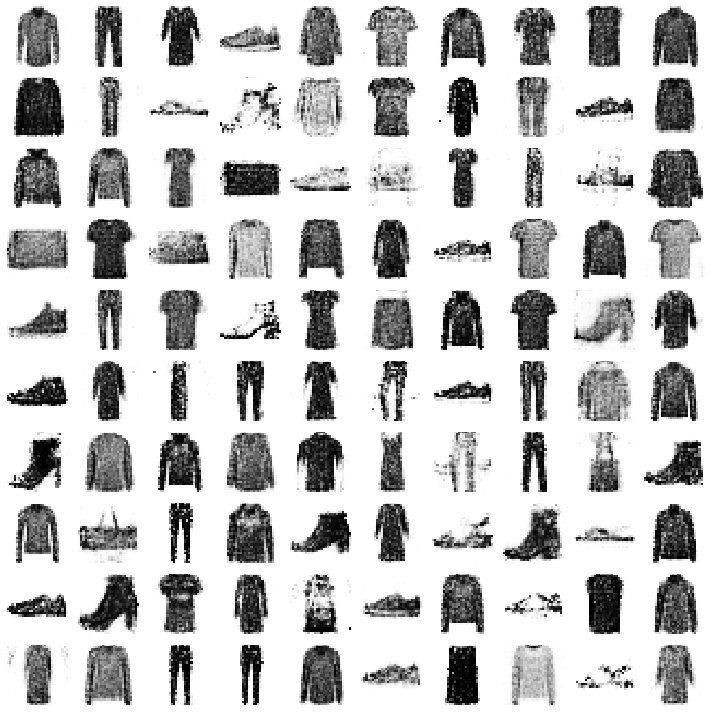

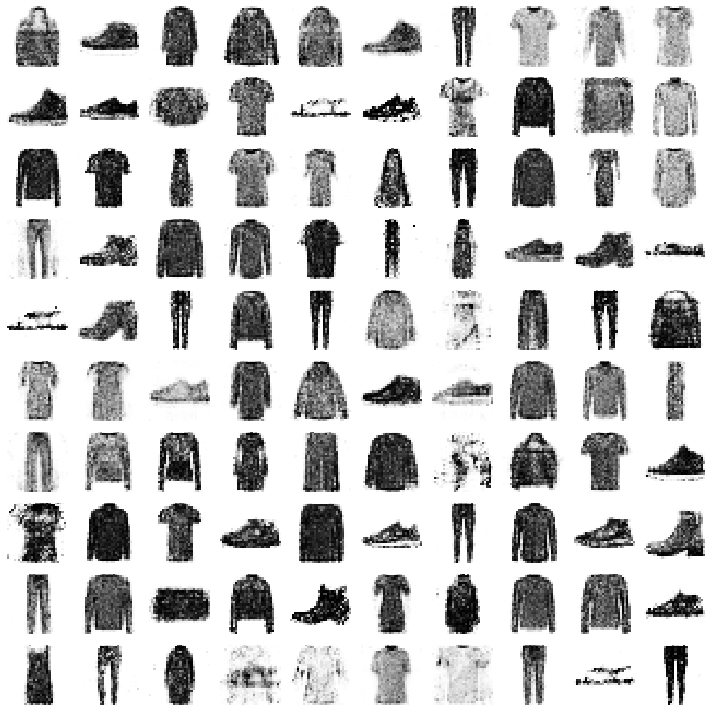

In [ ]:
# Train the network for 50 epochs and a batchsize of 100
train(images_train, epochs=50, batchSize=100, randomDim=100)

In [ ]:
ls

gan_generated_image_epoch_10.png  gan_generated_image_epoch_35.png
gan_generated_image_epoch_15.png  gan_generated_image_epoch_40.png
gan_generated_image_epoch_1.png   gan_generated_image_epoch_45.png
gan_generated_image_epoch_20.png  gan_generated_image_epoch_50.png
gan_generated_image_epoch_25.png  gan_generated_image_epoch_5.png
gan_generated_image_epoch_30.png  sample_data/


## Download the Generated Images

In [ ]:
from google.colab import files

In [ ]:
import os

In [ ]:
os.listdir()

['.config',
 'gan_generated_image_epoch_50.png',
 'gan_generated_image_epoch_1.png',
 'gan_generated_image_epoch_35.png',
 'gan_generated_image_epoch_40.png',
 'gan_generated_image_epoch_5.png',
 'gan_generated_image_epoch_15.png',
 'gan_generated_image_epoch_10.png',
 'gan_generated_image_epoch_25.png',
 'gan_generated_image_epoch_30.png',
 'gan_generated_image_epoch_45.png',
 'gan_generated_image_epoch_20.png',
 'sample_data']

In [ ]:
for f in ['gan_generated_image_epoch_10.png',
 'gan_generated_image_epoch_20.png',
 'gan_generated_image_epoch_35.png',
 'gan_generated_image_epoch_25.png',
 'gan_generated_image_epoch_30.png',
 'gan_generated_image_epoch_15.png',
 'gan_generated_image_epoch_5.png',
 'gan_generated_image_epoch_1.png']:
 files.download(f)